2023-07-24 11:36:43.276674: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-24 11:36:43.277325: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-24 11:36:43.277379: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (oscar-HP-ENVY-15-Notebook-PC): /proc/driver/nvidia/version does not exist
2023-07-24 11:36:43.279813: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10


/home/oscar/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


22/22 - 2s - loss: 0.4617 - mae: 0.3898 - val_loss: 0.0108 - val_mae: 0.0728 - 2s/epoch - 112ms/step
Epoch 2/10
22/22 - 0s - loss: 0.0563 - mae: 0.1604 - val_loss: 0.0051 - val_mae: 0.0421 - 99ms/epoch - 4ms/step
Epoch 3/10
22/22 - 0s - loss: 0.0233 - mae: 0.0990 - val_loss: 0.0069 - val_mae: 0.0620 - 101ms/epoch - 5ms/step
Epoch 4/10
22/22 - 0s - loss: 0.0186 - mae: 0.0731 - val_loss: 0.0036 - val_mae: 0.0345 - 97ms/epoch - 4ms/step
Epoch 5/10
22/22 - 0s - loss: 0.0176 - mae: 0.0660 - val_loss: 0.0027 - val_mae: 0.0255 - 100ms/epoch - 5ms/step
Epoch 6/10
22/22 - 0s - loss: 0.0173 - mae: 0.0634 - val_loss: 0.0025 - val_mae: 0.0225 - 87ms/epoch - 4ms/step
Epoch 7/10
22/22 - 0s - loss: 0.0171 - mae: 0.0623 - val_loss: 0.0024 - val_mae: 0.0204 - 86ms/epoch - 4ms/step
Epoch 8/10
22/22 - 0s - loss: 0.0170 - mae: 0.0613 - val_loss: 0.0023 - val_mae: 0.0191 - 83ms/epoch - 4ms/step
Epoch 9/10
22/22 - 0s - loss: 0.0169 - mae: 0.0605 - val_loss: 0.0023 - val_mae: 0.0183 - 85ms/epoch - 4ms/step
E

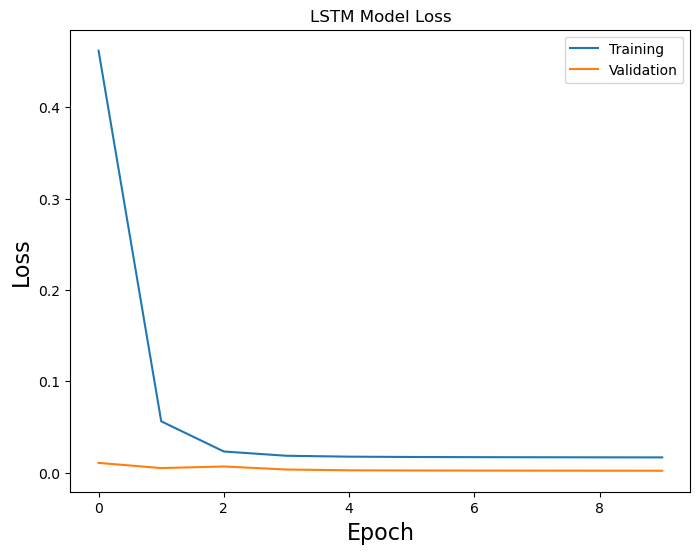

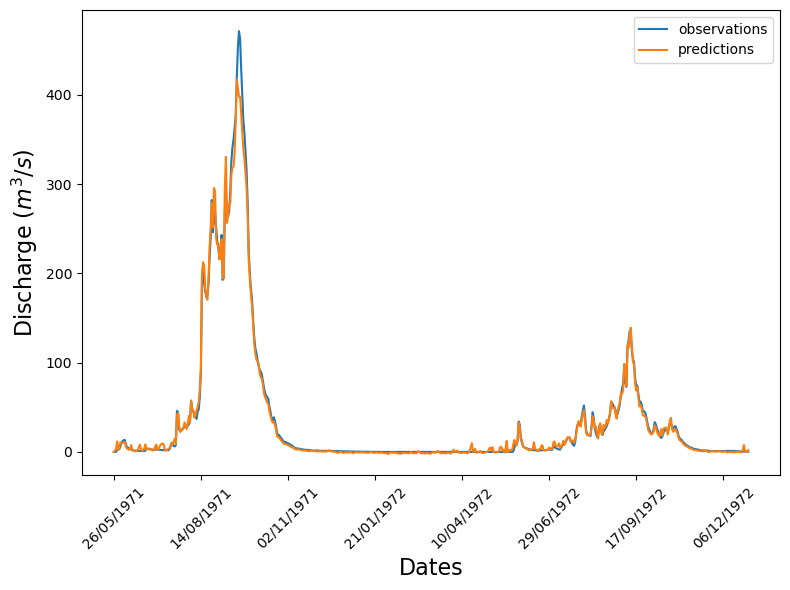

R2: 0.993
NSE: 0.991
RMSE: 7.398
MAE: 3.333


In [4]:
# import libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
# import keras modules
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

# import additional modules
from statistics import mean
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Reshape, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model


# function to transform time series to supervised learning series
from pandas import DataFrame
from pandas import concat

# load dataset

import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('beterou_62_72_cal.csv') 
data.columns = ['Dates','Prec','ETP','Debit']
cal_data, val_data = train_test_split(data, test_size=0.2, shuffle=False)


""""
cal_data =  pd.read_csv('cal.csv')

val_data = pd.read_csv('val.csv')
cal_data.columns = ['Date','Prec','ETP','Debit']

val_data.columns = ['Date','Prec','ETP','Debit']

"""

cal_date =  cal_data['Dates']
val_date =  val_data['Dates']
cal_data.drop(['Dates'], inplace =True, axis=1)
val_data.drop(['Dates'], inplace =True, axis=1)

# set default parameter values for lstm model

learning_rate = 1e-2
num_lstm_units = 100
num_epochs=10
num_batch_size= 100


# define a helper-function for log-dir-name
def log_dir_name(learning_rate, num_lstm_units,
                 num_epochs, num_batch_size):

    # the dir-name for the TensorBoard log-dir
    s = "./5_logs/lr_{0:.0e}_lstm_{1}_epochs_{2}_batch_{3}/"

    # insert all the hyper-parameters in the dir-name
    log_dir = s.format(learning_rate,
                       num_lstm_units,
                       num_epochs,
                       num_batch_size)

    return log_dir

def preprocessing(df):
    # select values of dataframe
    values = df.values

    # remove output data y to rescale later
    values_x = np.delete(values, -1, axis=1)
    values_x.shape

    # rescale data between 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_x = scaler.fit_transform(values_x)
    # select values of output data y
    values_y = values[:, -1]

    # rescale manually output data y
    scaled_y = (values_y -values_y.mean())/ values_y.std()
    # reshape scaled date to concatenate with scaled input data
    scaled_y = scaled_y.reshape((scaled_y.shape[0], 1))

    # concatenate input data x and output data y
    scaled = np.concatenate((scaled_x, scaled_y), axis=1)
    return  scaled

scaled_cal = preprocessing(cal_data)

scaled_val = preprocessing(val_data)

# define the function who create a supervised dataset



def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# using function above
reframed_cal = series_to_supervised(scaled_cal, 1, 1)
reframed_val = series_to_supervised(scaled_val, 1, 1)

train = reframed_cal.values
test = reframed_val.values

# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_test, y_test = test[:, :-1], test[:, -1]


# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
#print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


def create_model(learning_rate, num_lstm_units, num_batch_size, num_epochs):
    
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_lstm_units:    Number of lstm units.
    num_epochs:        Number of epochs.
    num_batch_size:    Batch size of model.
    """
                       
    model = Sequential()
    
    model.add(LSTM(units=num_lstm_units, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(units=1))

    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model


# Define function that creates and trains a neural network with the given hyper-parameters
# and then evaluates its performance on the validation-set

def lstm_model(learning_rate, num_lstm_units, num_epochs, num_batch_size):
    
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_lstm_units:    Number of lstm units.
    num_epochs:        Number of epochs.
    num_batch_size:    Batch size of model.
    """

  
    # Create the neural network with these hyper-parameters.
    model = create_model(learning_rate=learning_rate,
                         num_lstm_units=num_lstm_units,
                         num_epochs=num_epochs,
                         num_batch_size=num_batch_size)

    # Dir-name for the TensorBoard log-files.
    log_dir = log_dir_name(learning_rate, num_lstm_units,
                           num_epochs, num_batch_size)
  
    callback_log = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        write_graph=True,
        write_grads=False,
        write_images=False)
   
    # Use Keras to train the model.
    history = model.fit(x=x_train,
                        y=y_train,
                        epochs=num_epochs,
                        batch_size=num_batch_size,
                        validation_split= 0.1,
                        
                        verbose=2, 
                        shuffle=False,
                        callbacks=[callback_log])

    # Get the loss on the validation-set
    # after the last training-epoch.
    val_loss = history.history['val_loss'][-1]
    yhat = model.predict(x_test)
    
    # find a set of hyper-parameters with the LOWEST fitness-value
    return val_loss,history, yhat

val_loss,history, yhat  = lstm_model(learning_rate, num_lstm_units, num_epochs, num_batch_size)


#plot history

plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend()

#def predictions(model,val_data):
# make a prediction

values_y = val_data['Debit'].values
inv_yhat = yhat * values_y.std() + values_y.mean()
#inv_yhat = yhat
# get initial values of y_test
inv_y = val_data['Debit'].iloc[0:-1]


# plot predicitons
dates_obs = val_date[:-1]

# Tracer les courbes en utilisant les dates comme axe des abscisses
# Tracer les courbes en utilisant les dates comme axe des abscisses
plt.figure(figsize=(8, 6))
plt.plot(dates_obs, inv_y, label='observations')
plt.plot(dates_obs, inv_yhat, label='predictions')
plt.xlabel('Dates', fontsize=16)
plt.ylabel('Discharge ($m^3/s$)', fontsize=16)
plt.legend()

# Configurer les ticks de l'axe des abscisses avec les dates
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Limiter le nombre de ticks affichés

plt.tight_layout()
plt.show()

# Model acuracy

# Coefficient of Determination (R2)
inv_yhat = inv_yhat.reshape(inv_yhat.shape[0])
correlation_matrix = np.corrcoef(inv_y, inv_yhat)
correlation_xy = correlation_matrix[0,1]
R2 = correlation_xy**2
print('R2: %.3f' % R2)

# Nash-Sutcliffe Efficiency (NSE) 
nse = 1 - ( sum((inv_y - inv_yhat) ** 2 ) / sum( (inv_y - mean(inv_y)) ** 2) ) 
print('NSE: %.3f' % nse)

# Root Meam Square Error (RMSE)
rmse = sqrt(1/len(inv_y)* sum((inv_y - inv_yhat) ** 2 ))
print('RMSE: %.3f' % rmse)

#Mean absolute error

mae = np.sum(np.abs(inv_y - inv_yhat), axis=0) / len(inv_yhat)
print('MAE: %.3f' % mae)


TypeError: object of type 'numpy.float64' has no len()

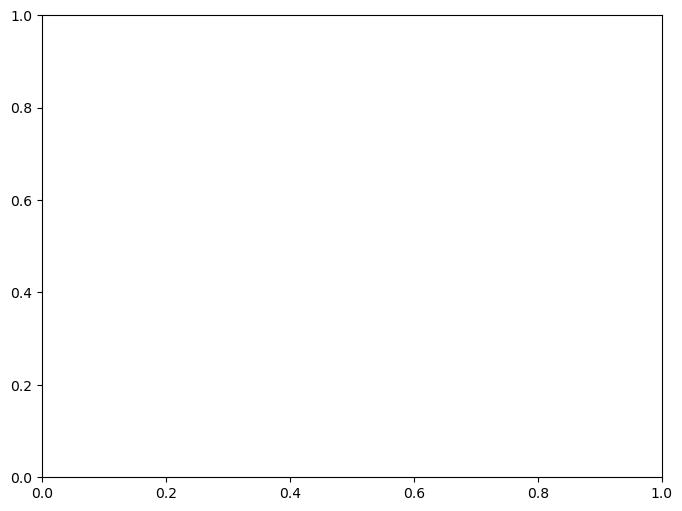

In [5]:
from scipy.stats import linregress

def corr_obs_lstm():
    data = pd.read_csv('beterou_62_72_cal.csv') 
       
     
    data.columns = ['Dates','Prec','ETP','Debit']
    
    fig, ax = plt.subplots(figsize=(8, 6))
    debits = data['Debit']
    x = debits
    indices = np.arange(len(debits[0]))
    fig, ax = plt.subplots()

    X = list(x[0][1:len(x[0])-1])
    Y = list(x[0][0:len(x[0])-2])

    ax.scatter(X,Y, label='(Q_obs_t,Q_obs_t-1)')
    ax.set_xlabel("Débits à la date t ($m^3/s$)")
    ax.set_ylabel("Débits à la date t-1 ($m^3/s$)")

    ax.legend(fontsize=10)

    d = linregress(X,Y)
    Z = np.linspace(0, max(x[0]))
    eqt = 'y = ' + str(round(d[0], 4)) + 'x + ' + str(round(d[1], 4))
    ax.plot(Z,d[0]*Z + d[1], label=eqt, color='red')
    ax.legend(fontsize=10)


        
    return fig

corr_obs_lstm()

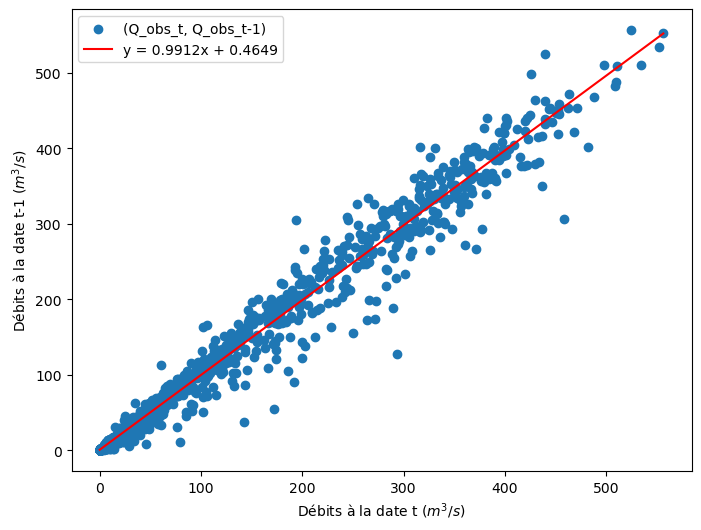

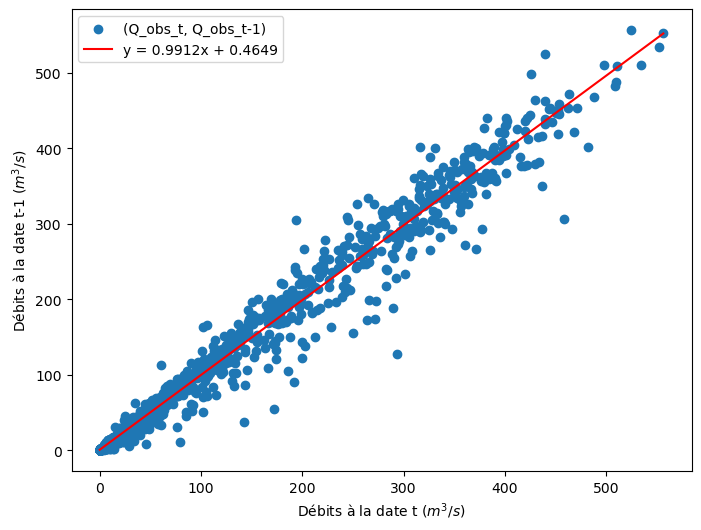

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

def corr_obs_lstm():
    data = pd.read_csv('beterou_62_72_cal.csv') 
    data.columns = ['Dates', 'Prec', 'ETP', 'Debit']
    
    fig, ax = plt.subplots(figsize=(8, 6))
    debits = data['Debit']
    x = debits.values
    X = x[1:]
    Y = x[:-1]

    ax.scatter(X, Y, label='(Q_obs_t, Q_obs_t-1)')
    ax.set_xlabel("Débits à la date t ($m^3/s$)")
    ax.set_ylabel("Débits à la date t-1 ($m^3/s$)")
    ax.legend(fontsize=10)

    d = linregress(X, Y)
    Z = np.linspace(0, max(X))
    eqt = f"y = {round(d.slope, 4)}x + {round(d.intercept, 4)}"
    ax.plot(Z, d.slope * Z + d.intercept, label=eqt, color='red')
    ax.legend(fontsize=10)

    return fig

corr_obs_lstm()


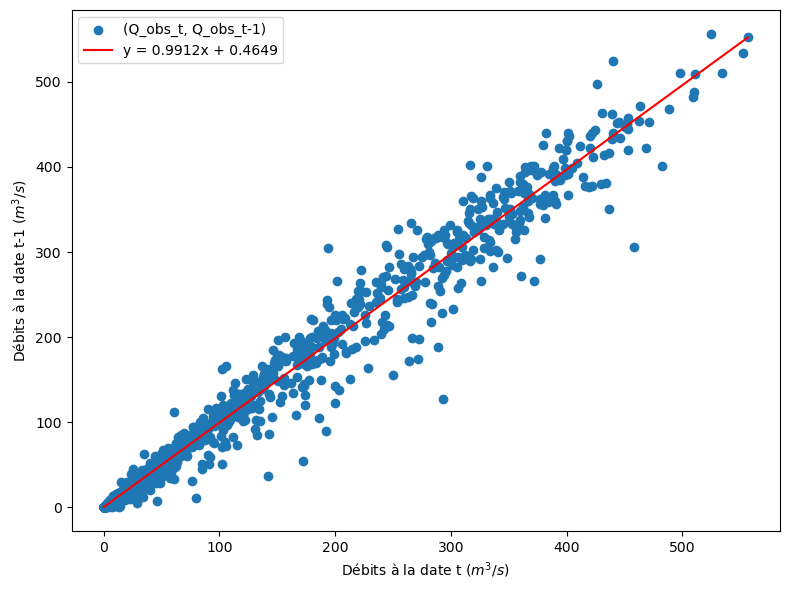

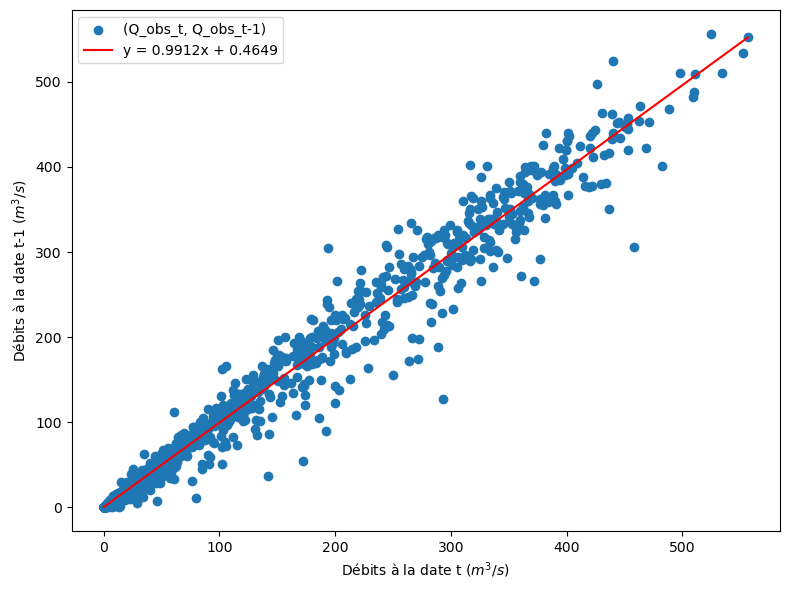

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

def corr_obs_lstm():
    data = pd.read_csv('beterou_62_72_cal.csv') 
    data.columns = ['Dates', 'Prec', 'ETP', 'Debit']
    
    fig, ax = plt.subplots(figsize=(8, 6))
    debits = data['Debit']
    x = debits.values
    X = x[1:]
    Y = x[:-1]

    ax.scatter(X, Y, label='(Q_obs_t, Q_obs_t-1)')
    ax.set_xlabel("Débits à la date t ($m^3/s$)")
    ax.set_ylabel("Débits à la date t-1 ($m^3/s$)")
    ax.legend(fontsize=10)

    d = linregress(X, Y)
    Z = np.linspace(0, max(X))
    eqt = f"y = {round(d.slope, 4)}x + {round(d.intercept, 4)}"
    ax.plot(Z, d.slope * Z + d.intercept, label=eqt, color='red')
    ax.legend(fontsize=10)

    plt.tight_layout()  # Add this line to improve the layout of the plot

    return fig

corr_obs_lstm()


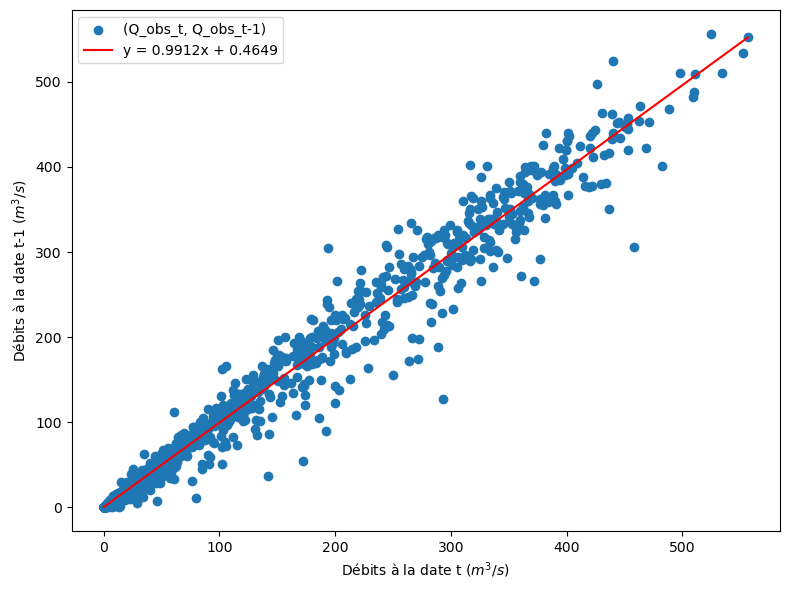

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

def corr_obs_lstm():
    data = pd.read_csv('beterou_62_72_cal.csv') 
    data.columns = ['Dates', 'Prec', 'ETP', 'Debit']
    
    debits = data['Debit']
    x = debits.values
    X = x[1:]
    Y = x[:-1]

    plt.figure(figsize=(8, 6))  # Set the figure size directly here
    plt.scatter(X, Y, label='(Q_obs_t, Q_obs_t-1)')
    plt.xlabel("Débits à la date t ($m^3/s$)")
    plt.ylabel("Débits à la date t-1 ($m^3/s$)")
    plt.legend(fontsize=10)

    d = linregress(X, Y)
    Z = np.linspace(0, max(X))
    eqt = f"y = {round(d.slope, 4)}x + {round(d.intercept, 4)}"
    plt.plot(Z, d.slope * Z + d.intercept, label=eqt, color='red')
    plt.legend(fontsize=10)

    plt.tight_layout()  # Add this line to improve the layout of the plot

    plt.show()  # Show the plot

corr_obs_lstm()


Epoch 1/10


/home/oscar/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


121/121 - 2s - loss: 0.1849 - mae: 0.1752 - val_loss: 0.0332 - val_mae: 0.0735 - 2s/epoch - 19ms/step
Epoch 2/10
121/121 - 0s - loss: 0.0316 - mae: 0.0684 - val_loss: 0.0264 - val_mae: 0.0666 - 268ms/epoch - 2ms/step
Epoch 3/10
121/121 - 0s - loss: 0.0259 - mae: 0.0681 - val_loss: 0.0271 - val_mae: 0.0876 - 265ms/epoch - 2ms/step
Epoch 4/10
121/121 - 0s - loss: 0.0243 - mae: 0.0689 - val_loss: 0.0279 - val_mae: 0.0943 - 271ms/epoch - 2ms/step
Epoch 5/10
121/121 - 0s - loss: 0.0235 - mae: 0.0686 - val_loss: 0.0282 - val_mae: 0.0929 - 262ms/epoch - 2ms/step
Epoch 6/10
121/121 - 0s - loss: 0.0232 - mae: 0.0676 - val_loss: 0.0288 - val_mae: 0.0923 - 260ms/epoch - 2ms/step
Epoch 7/10
121/121 - 0s - loss: 0.0229 - mae: 0.0668 - val_loss: 0.0294 - val_mae: 0.0925 - 275ms/epoch - 2ms/step
Epoch 8/10
121/121 - 0s - loss: 0.0227 - mae: 0.0660 - val_loss: 0.0298 - val_mae: 0.0928 - 256ms/epoch - 2ms/step
Epoch 9/10
121/121 - 0s - loss: 0.0225 - mae: 0.0652 - val_loss: 0.0301 - val_mae: 0.0927 - 2

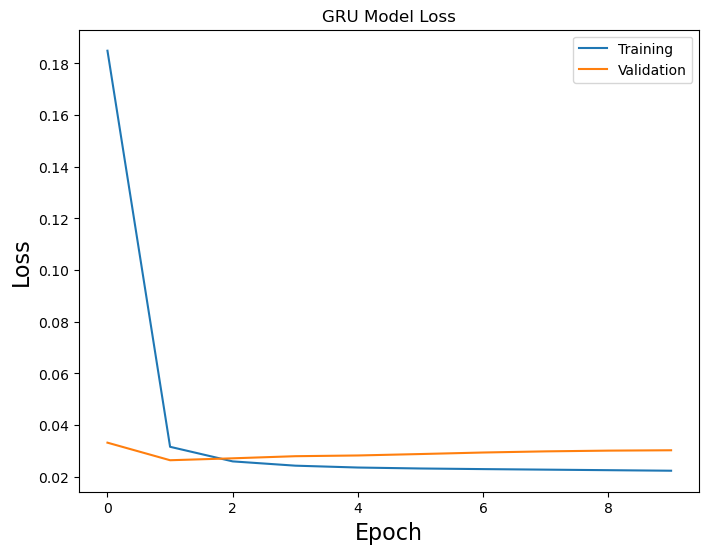

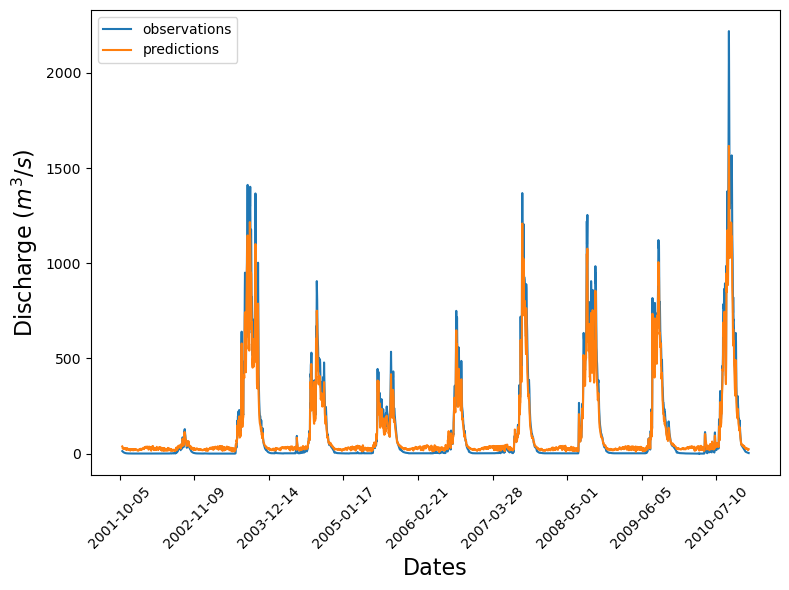

R2: 0.993
NSE: 0.958
RMSE: 52.932
MAE: 34.027


In [31]:
# import libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
# import keras modules
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

# import additional modules
from statistics import mean
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Reshape, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model


# function to transform time series to supervised learning series
from pandas import DataFrame
from pandas import concat

# load dataset

import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_excel('save_45.xlsx') 
data.columns = ['Dates','Prec','ETP','Debit']
cal_data, val_data = train_test_split(data, test_size=0.2, shuffle=False)


""""
cal_data =  pd.read_csv('cal.csv')

val_data = pd.read_csv('val.csv')
cal_data.columns = ['Date','Prec','ETP','Debit']

val_data.columns = ['Date','Prec','ETP','Debit']

"""

cal_date =  cal_data['Dates']
val_date =  val_data['Dates']
cal_data.drop(['Dates'], inplace =True, axis=1)
val_data.drop(['Dates'], inplace =True, axis=1)

# set default parameter values for lstm model

learning_rate = 1e-2
num_gru_units = 10
num_epochs=10
num_batch_size= 100


# define a helper-function for log-dir-name
def log_dir_name(learning_rate, num_lstm_units,
                 num_epochs, num_batch_size):

    # the dir-name for the TensorBoard log-dir
    s = "./5_logs/lr_{0:.0e}_lstm_{1}_epochs_{2}_batch_{3}/"

    # insert all the hyper-parameters in the dir-name
    log_dir = s.format(learning_rate,
                       num_lstm_units,
                       num_epochs,
                       num_batch_size)

    return log_dir

def preprocessing(df):
    # select values of dataframe
    values = df.values

    # remove output data y to rescale later
    values_x = np.delete(values, -1, axis=1)
    values_x.shape

    # rescale data between 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_x = scaler.fit_transform(values_x)
    # select values of output data y
    values_y = values[:, -1]

    # rescale manually output data y
    scaled_y = (values_y -values_y.mean())/ values_y.std()
    # reshape scaled date to concatenate with scaled input data
    scaled_y = scaled_y.reshape((scaled_y.shape[0], 1))

    # concatenate input data x and output data y
    scaled = np.concatenate((scaled_x, scaled_y), axis=1)
    return  scaled

scaled_cal = preprocessing(cal_data)

scaled_val = preprocessing(val_data)

# define the function who create a supervised dataset



def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# using function above
reframed_cal = series_to_supervised(scaled_cal, 1, 1)
reframed_val = series_to_supervised(scaled_val, 1, 1)

train = reframed_cal.values
test = reframed_val.values

# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_test, y_test = test[:, :-1], test[:, -1]


# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
#print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


def create_gru_model(learning_rate, num_gru_units, num_batch_size, num_epochs):
    
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_lstm_units:    Number of lstm units.
    num_epochs:        Number of epochs.
    num_batch_size:    Batch size of model.
    """
                       
    model = Sequential()
    
    model.add(GRU(units=num_gru_units, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(units=1))

    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model



# Define function that creates and trains a neural network with the given hyper-parameters
# and then evaluates its performance on the validation-set

def gru_model(learning_rate, num_gru_units, num_epochs, num_batch_size):
    
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_lstm_units:    Number of gru units.
    num_epochs:        Number of epochs.
    num_batch_size:    Batch size of model.
    """

  
    # Create the neural network with these hyper-parameters.
    model = create_gru_model(learning_rate,
                         num_gru_units,
                         num_epochs,
                         num_batch_size)

    # Dir-name for the TensorBoard log-files.
    log_dir = log_dir_name(learning_rate, num_gru_units,
                           num_epochs, num_batch_size)
  
    callback_log = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        write_graph=True,
        write_grads=False,
        write_images=False)
   
    # Use Keras to train the model.
    history = model.fit(x=x_train,
                        y=y_train,
                        epochs=num_epochs,
                        batch_size=num_batch_size,
                        validation_split= 0.1,
                        
                        verbose=2, 
                        shuffle=False,
                        callbacks=[callback_log])

    # Get the loss on the validation-set
    # after the last training-epoch.
    val_loss = history.history['val_loss'][-1]
    yhat = model.predict(x_test)
    model.save('trained_gru_model.h5')

    
    # find a set of hyper-parameters with the LOWEST fitness-value
    return val_loss,history, yhat



val_loss,history, yhat  = gru_model(learning_rate, num_gru_units, num_epochs, num_batch_size)


#plot history

plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('GRU Model Loss')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend()

#def predictions(model,val_data):
# make a prediction

values_y = val_data['Debit'].values
inv_yhat = yhat * values_y.std() + values_y.mean()
#inv_yhat = yhat
# get initial values of y_test
inv_y = val_data['Debit'].iloc[0:-1]


# plot predicitons
dates_obs = val_date[:-1]

# Tracer les courbes en utilisant les dates comme axe des abscisses
# Tracer les courbes en utilisant les dates comme axe des abscisses
plt.figure(figsize=(8, 6))
plt.plot(dates_obs, inv_y, label='observations')
plt.plot(dates_obs, inv_yhat, label='predictions')
plt.xlabel('Dates', fontsize=16)
plt.ylabel('Discharge ($m^3/s$)', fontsize=16)
plt.legend()

# Configurer les ticks de l'axe des abscisses avec les dates
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Limiter le nombre de ticks affichés

plt.tight_layout()
plt.show()

# Model acuracy

# Coefficient of Determination (R2)
inv_yhat = inv_yhat.reshape(inv_yhat.shape[0])
correlation_matrix = np.corrcoef(inv_y, inv_yhat)
correlation_xy = correlation_matrix[0,1]
R2 = correlation_xy**2
print('R2: %.3f' % R2)

# Nash-Sutcliffe Efficiency (NSE) 
nse = 1 - ( sum((inv_y - inv_yhat) ** 2 ) / sum( (inv_y - mean(inv_y)) ** 2) ) 
print('NSE: %.3f' % nse)

# Root Meam Square Error (RMSE)
rmse = sqrt(1/len(inv_y)* sum((inv_y - inv_yhat) ** 2 ))
print('RMSE: %.3f' % rmse)

#Mean absolute error

mae = np.sum(np.abs(inv_y - inv_yhat), axis=0) / len(inv_yhat)
print('MAE: %.3f' % mae)


In [42]:
test_data =  pd.read_csv('july_2011.csv')
test_data.columns = ['Dates','Prec','ETP','Debit']
test_data

,Dates,Prec,ETP,Debit
0,01/08/2011,3.7571,3.415808,0.060274
1,02/08/2011,3.1547,2.217331,0.037629
2,03/08/2011,20.6947,2.441215,0.034249
3,04/08/2011,0.0000,3.551707,0.053739
4,05/08/2011,11.8528,2.861453,0.093546
5,06/08/2011,5.2237,3.152356,0.075370
6,07/08/2011,0.0000,2.587835,0.086749
7,08/08/2011,0.7901,2.856440,0.093096
8,09/08/2011,0.5943,2.860855,0.099931
9,10/08/2011,11.6253,2.683103,0.059485


In [43]:
test_date =  test_data['Dates']
test_data.drop(['Dates'], inplace =True, axis=1)

In [44]:

scaled_test = preprocessing(test_data)
reframed_test = series_to_supervised(scaled_test, 1, 1)


test_for_prediction = reframed_test.values


x_test, y_test = test_for_prediction[:, :-1], test_for_prediction[:, -1]


# reshape input to be 3D [samples, timesteps, features]

x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

In [45]:
from tensorflow.keras.models import load_model

def load_and_predict_model(model_file, x_test):
    # Charger le modèle depuis le fichier.
    model = load_model(model_file)

    # Faire des prédictions avec le modèle chargé.
    yhat = model.predict(x_test)

    return yhat

# Faire des prédictions avec le modèle sauvegardé.
model_file = 'trained_gru_model.h5'

values_y = test_data['Debit'].values

yhat = load_and_predict_model(model_file, x_test)


1/1 [==============================] - 0s 322ms/step


In [47]:
inv_yhat = yhat * values_y.std() + values_y.mean()


In [48]:
pd.DataFrame(inv_yhat)

,0
0,0.165242
1,0.165937
2,0.143761
3,0.179082
4,0.186736
5,0.175792
6,0.191690
7,0.195576
8,0.199242
9,0.160168


In [51]:
test_date

0     01/08/2011
1     02/08/2011
2     03/08/2011
3     04/08/2011
4     05/08/2011
5     06/08/2011
6     07/08/2011
7     08/08/2011
8     09/08/2011
9     10/08/2011
10    11/08/2011
11    12/08/2011
12    13/08/2011
13    14/08/2011
14    15/08/2011
15    16/08/2011
16    17/08/2011
17    18/08/2011
18    19/08/2011
19    20/08/2011
20    21/08/2011
21    22/08/2011
22    23/08/2011
23    24/08/2011
24    25/08/2011
25    26/08/2011
26    27/08/2011
27    28/08/2011
28    29/08/2011
29    30/08/2011
Name: Dates, dtype: object

In [52]:
dates_obs = test_date[:-1]
dates_obs

0     01/08/2011
1     02/08/2011
2     03/08/2011
3     04/08/2011
4     05/08/2011
5     06/08/2011
6     07/08/2011
7     08/08/2011
8     09/08/2011
9     10/08/2011
10    11/08/2011
11    12/08/2011
12    13/08/2011
13    14/08/2011
14    15/08/2011
15    16/08/2011
16    17/08/2011
17    18/08/2011
18    19/08/2011
19    20/08/2011
20    21/08/2011
21    22/08/2011
22    23/08/2011
23    24/08/2011
24    25/08/2011
25    26/08/2011
26    27/08/2011
27    28/08/2011
28    29/08/2011
Name: Dates, dtype: object

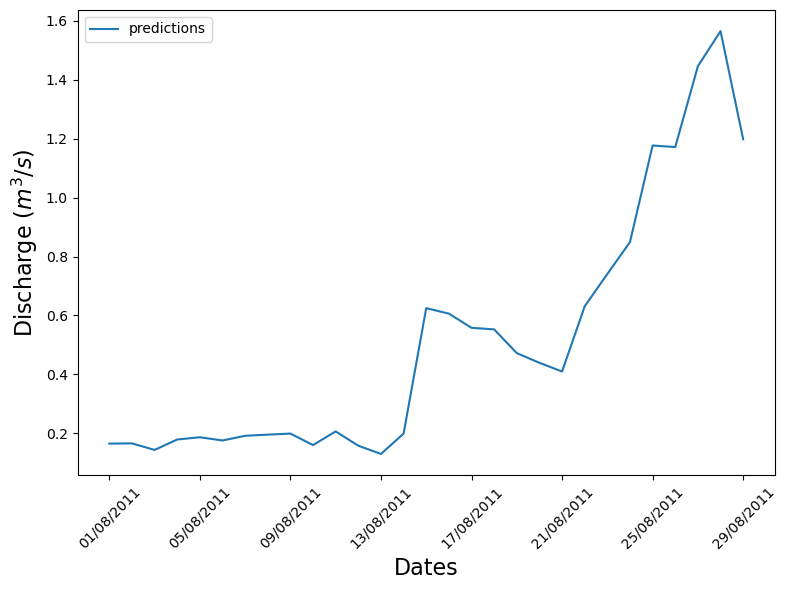

In [54]:

# plot predicitons
dates_obs = test_date[:-1]

# Tracer les courbes en utilisant les dates comme axe des abscisses
# Tracer les courbes en utilisant les dates comme axe des abscisses
plt.figure(figsize=(8, 6))
plt.plot(dates_obs, inv_yhat, label='predictions')
plt.xlabel('Dates', fontsize=16)
plt.ylabel('Discharge ($m^3/s$)', fontsize=16)
plt.legend()

# Configurer les ticks de l'axe des abscisses avec les dates
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Limiter le nombre de ticks affichés

plt.tight_layout()
plt.savefig('prediction.png')
plt.show()


# Autres

In [2]:
# import libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
# import keras modules
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

# import additional modules
from statistics import mean
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Reshape, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model


# function to transform time series to supervised learning series
from pandas import DataFrame
from pandas import concat

# load dataset

import pandas as pd
from sklearn.model_selection import train_test_split

def get_gru_debit(learning_rate, num_gru_units, num_epochs, num_batch_size):
    # load dataset
    data = pd.read_csv('beterou_62_72_cal.csv') 
    data.columns = ['Dates','Prec','ETP','Debit']
    cal_data, val_data = train_test_split(data, test_size=0.2, shuffle=False)
    cal_date = cal_data['Dates']
    val_date = val_data['Dates']
    cal_data.drop(['Dates'], inplace=True, axis=1)
    val_data.drop(['Dates'], inplace=True, axis=1)

    # preprocessing
    scaled_cal = preprocessing(cal_data)
    scaled_val = preprocessing(val_data)

    # supervised dataset
    reframed_cal = series_to_supervised(scaled_cal, 1, 1)
    reframed_val = series_to_supervised(scaled_val, 1, 1)

    train = reframed_cal.values
    test = reframed_val.values

    # split into input and outputs
    x_train, y_train = train[:, :-1], train[:, -1]
    x_test, y_test = test[:, :-1], test[:, -1]

    # reshape input to be 3D [samples, timesteps, features]
    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

    def create_gru_model(learning_rate, num_gru_units, num_batch_size, num_epochs):
        """
        Hyper-parameters:
        learning_rate:     Learning-rate for the optimizer.
        num_lstm_units:    Number of lstm units.
        num_epochs:        Number of epochs.
        num_batch_size:    Batch size of model.
        """
        model = Sequential()
        model.add(GRU(units=num_gru_units, input_shape=(x_train.shape[1], x_train.shape[2])))
        model.add(Dense(units=1))
        optimizer = Adam(lr=learning_rate)
        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
        return model

    def log_dir_name(learning_rate, num_gru_units, num_epochs, num_batch_size):
        # the dir-name for the TensorBoard log-dir
        s = "./5_logs/lr_{0:.0e}_gru_{1}_epochs_{2}_batch_{3}/"
        # insert all the hyper-parameters in the dir-name
        log_dir = s.format(learning_rate, num_gru_units, num_epochs, num_batch_size)
        return log_dir

    def gru_model(learning_rate, num_gru_units, num_epochs, num_batch_size):
        """
        Hyper-parameters:
        learning_rate:     Learning-rate for the optimizer.
        num_gru_units:    Number of gru units.
        num_epochs:        Number of epochs.
        num_batch_size:    Batch size of model.
        """
        # Create the neural network with these hyper-parameters.
        model = create_gru_model(learning_rate, num_gru_units, num_epochs, num_batch_size)
        # Dir-name for the TensorBoard log-files.
        log_dir = log_dir_name(learning_rate, num_gru_units, num_epochs, num_batch_size)
        callback_log = TensorBoard(
            log_dir=log_dir,
            histogram_freq=0,
            write_graph=True,
            write_grads=False,
            write_images=False
        )
        # Use Keras to train the model.
        history = model.fit(
            x=x_train,
            y=y_train,
            epochs=num_epochs,
            batch_size=num_batch_size,
            validation_split=0.1,
            verbose=2,
            shuffle=False,
            callbacks=[callback_log]
        )
        # Get the loss on the validation-set after the last training-epoch.
        val_loss = history.history['val_loss'][-1]
        yhat = model.predict(x_test)
        return val_loss, history, yhat

    # Call the gru_model function
    val_loss, history, yhat = gru_model(learning_rate, num_gru_units, num_epochs, num_batch_size)

    return val_loss, history, yhat


2023-07-18 10:28:48.661002: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 10:28:49.530787: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-18 10:28:49.530813: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-18 10:28:49.709611: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-18 10:28:51.920402: W tensorflow/stream_executor/platform/de

In [4]:
val_loss, history, yhat = get_gru_debit(learning_rate, num_gru_units, num_epochs, num_batch_size)


Epoch 1/10


/home/oscar/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


22/22 - 3s - loss: 0.9455 - mae: 0.6710 - val_loss: 0.1037 - val_mae: 0.2163 - 3s/epoch - 118ms/step
Epoch 2/10
22/22 - 0s - loss: 0.2424 - mae: 0.2708 - val_loss: 0.0110 - val_mae: 0.0462 - 75ms/epoch - 3ms/step
Epoch 3/10
22/22 - 0s - loss: 0.0551 - mae: 0.1338 - val_loss: 0.0158 - val_mae: 0.1039 - 75ms/epoch - 3ms/step
Epoch 4/10
22/22 - 0s - loss: 0.0429 - mae: 0.1278 - val_loss: 0.0089 - val_mae: 0.0683 - 77ms/epoch - 4ms/step
Epoch 5/10
22/22 - 0s - loss: 0.0354 - mae: 0.0985 - val_loss: 0.0057 - val_mae: 0.0439 - 77ms/epoch - 3ms/step
Epoch 6/10
22/22 - 0s - loss: 0.0314 - mae: 0.0863 - val_loss: 0.0052 - val_mae: 0.0388 - 79ms/epoch - 4ms/step
Epoch 7/10
22/22 - 0s - loss: 0.0286 - mae: 0.0796 - val_loss: 0.0045 - val_mae: 0.0329 - 78ms/epoch - 4ms/step
Epoch 8/10
22/22 - 0s - loss: 0.0264 - mae: 0.0742 - val_loss: 0.0039 - val_mae: 0.0290 - 78ms/epoch - 4ms/step
Epoch 9/10
22/22 - 0s - loss: 0.0247 - mae: 0.0709 - val_loss: 0.0035 - val_mae: 0.0272 - 76ms/epoch - 3ms/step
Epo

In [2]:

# import libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
# import keras modules
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

# import additional modules
from statistics import mean
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Reshape, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model


# function to transform time series to supervised learning series
from pandas import DataFrame
from pandas import concat

# load dataset

import pandas as pd
from sklearn.model_selection import train_test_split

def performance(val_data,yhat):
    values_y = val_data['Debit'].values
    inv_yhat = yhat * values_y.std() + values_y.mean()

    # get initial values of y_test
    inv_y = val_data['Debit'].iloc[0:-1]

    inv_yhat = inv_yhat.reshape(inv_yhat.shape[0])
    correlation_matrix = np.corrcoef(inv_y, inv_yhat)
    correlation_xy = correlation_matrix[0,1]
    R2 = correlation_xy**2


    # Nash-Sutcliffe Efficiency (NSE) 
    nse = 1 - ( sum((inv_y - inv_yhat) ** 2 ) / sum( (inv_y - mean(inv_y)) ** 2) ) 
    
    # Root Meam Square Error (RMSE)
    rmse = sqrt(1/len(inv_y)* sum((inv_y - inv_yhat) ** 2 ))
    
    #Mean absolute error

    mae = np.sum(np.abs(inv_y - inv_yhat), axis=0) / len(inv_yhat)
    
    return inv_yhat ,inv_y, R2,nse, rmse, mae



def gru_debits(data, cal_data, val_data, learning_rate, num_gru_units, num_epochs, num_batch_size):
    
    
    cal_date = cal_data['Dates']
    val_date = val_data['Dates']
    cal_data.drop(['Dates'], inplace=True, axis=1)
    val_data.drop(['Dates'], inplace=True, axis=1)

    # preprocessing
    scaled_cal = preprocessing(cal_data)
    scaled_val = preprocessing(val_data)

    # supervised dataset
    reframed_cal = series_to_supervised(scaled_cal, 1, 1)
    reframed_val = series_to_supervised(scaled_val, 1, 1)

    train = reframed_cal.values
    test = reframed_val.values

    # split into input and outputs
    x_train, y_train = train[:, :-1], train[:, -1]
    x_test, y_test = test[:, :-1], test[:, -1]

    # reshape input to be 3D [samples, timesteps, features]
    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

    def create_gru_model(learning_rate, num_gru_units, num_batch_size, num_epochs):
        """
        Hyper-parameters:
        learning_rate:     Learning-rate for the optimizer.
        num_lstm_units:    Number of lstm units.
        num_epochs:        Number of epochs.
        num_batch_size:    Batch size of model.
        """
        model = Sequential()
        model.add(GRU(units=num_gru_units, input_shape=(x_train.shape[1], x_train.shape[2])))
        model.add(Dense(units=1))
        optimizer = Adam(lr=learning_rate)
        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
        return model

    def log_dir_name(learning_rate, num_gru_units, num_epochs, num_batch_size):
        # the dir-name for the TensorBoard log-dir
        s = "./5_logs/lr_{0:.0e}_gru_{1}_epochs_{2}_batch_{3}/"
        # insert all the hyper-parameters in the dir-name
        log_dir = s.format(learning_rate, num_gru_units, num_epochs, num_batch_size)
        return log_dir

    def gru_model(learning_rate, num_gru_units, num_epochs, num_batch_size):
        """
        Hyper-parameters:
        learning_rate:     Learning-rate for the optimizer.
        num_gru_units:    Number of gru units.
        num_epochs:        Number of epochs.
        num_batch_size:    Batch size of model.
        """
        # Create the neural network with these hyper-parameters.
        model = create_gru_model(learning_rate, num_gru_units, num_epochs, num_batch_size)
        # Dir-name for the TensorBoard log-files.
        log_dir = log_dir_name(learning_rate, num_gru_units, num_epochs, num_batch_size)
        callback_log = TensorBoard(
            log_dir=log_dir,
            histogram_freq=0,
            write_graph=True,
            write_grads=False,
            write_images=False
        )
        # Use Keras to train the model.
        history = model.fit(
            x=x_train,
            y=y_train,
            epochs=num_epochs,
            batch_size=num_batch_size,
            validation_split=0.1,
            verbose=2,
            shuffle=False,
            callbacks=[callback_log]
        )
        # Get the loss on the validation-set after the last training-epoch.
        val_loss = history.history['val_loss'][-1]
        yhat = model.predict(x_test)
        return val_loss, history, yhat

    # Call the gru_model function
    val_loss, history, yhat = gru_model(learning_rate, num_gru_units, num_epochs, num_batch_size)
    inv_yhat,inv_y, R2,nse, rmse, mae = performance(val_data,yhat)

    return (inv_yhat,inv_y, R2,nse, rmse, mae)


def gru_plot_second():
         
        data = pd.read_excel('beterou_62_72_cal.csv') 
        data.columns = ['Dates','Prec','ETP','Debit']           

        #print("Début lstm modele")
        #cal_data, val_data = split_cal_val(data, cal_start , cal_end , val_start, val_end)
        cal_data, val_data = train_test_split(data, test_size=0.2, shuffle=False)
        


        cal_date =  cal_data['Dates']
        val_date =  val_data['Dates']


        learning_rate = 1e-2
        num_gru_units = 10
        num_epochs=10
        num_batch_size= 100
        inv_yhat,inv_y, R2,nse, rmse, mae= gru_debits(data, cal_data, val_data, learning_rate, num_gru_units, num_epochs, num_batch_size)
        dates_obs = val_date[:-1]
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(dates_obs,inv_y, label='observations')
        ax.plot(dates_obs,inv_yhat, label='GRU predictions')
        ax.set_xlabel('Days', fontsize=16)
        ax.set_ylabel('Discharge ($m^3/s$)', fontsize=16)
        ax.legend()
        plt.xticks(rotation=45)
        plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Limiter le nombre de ticks affichés

        plt.tight_layout()
        return fig

gru_plot_second()

ValueError: Excel file format cannot be determined, you must specify an engine manually.

In [3]:
def gru_plot_second():
    data = pd.read_csv('beterou_62_72_cal.csv')
    data.columns = ['Dates','Prec','ETP','Debit']
    cal_data, val_data = train_test_split(data, test_size=0.2, shuffle=False)

    cal_date = cal_data['Dates']
    val_date = val_data['Dates']

    learning_rate = 1e-2
    num_gru_units = 10
    num_epochs = 10
    num_batch_size = 100
    inv_yhat, inv_y, R2, nse, rmse, mae = gru_debits(data, cal_data, val_data, learning_rate, num_gru_units, num_epochs, num_batch_size)
    dates_obs = val_date[:-1]
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(dates_obs, inv_y, label='observations')
    ax.plot(dates_obs, inv_yhat, label='GRU predictions')
    ax.set_xlabel('Days', fontsize=16)
    ax.set_ylabel('Discharge ($m^3/s$)', fontsize=16)
    ax.legend()
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Limiter le nombre de ticks affichés

    plt.tight_layout()
    return fig

gru_plot_second()

NameError: name 'preprocessing' is not defined